<a href="https://colab.research.google.com/github/EllenBonafin/machine-learning-clusterr/blob/main/ML2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTANDO

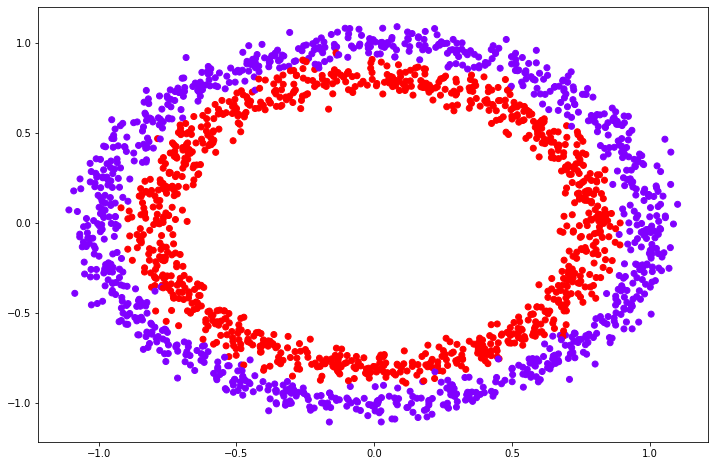

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
db = pd.read_csv('/content/Base8.csv')
#data = make_blobs(n_samples=200,n_features=2,centers=4,cluster_std=1,random_state=23)
plt.figure(figsize=(12,8))
x = []
x.append(db.iloc[:,0:2].values)
x.append(db.iloc[:,2:3].values)
x
plt.scatter(x[0][:,0],x[0][:,1],c=x[1],cmap="rainbow")


KMEANS

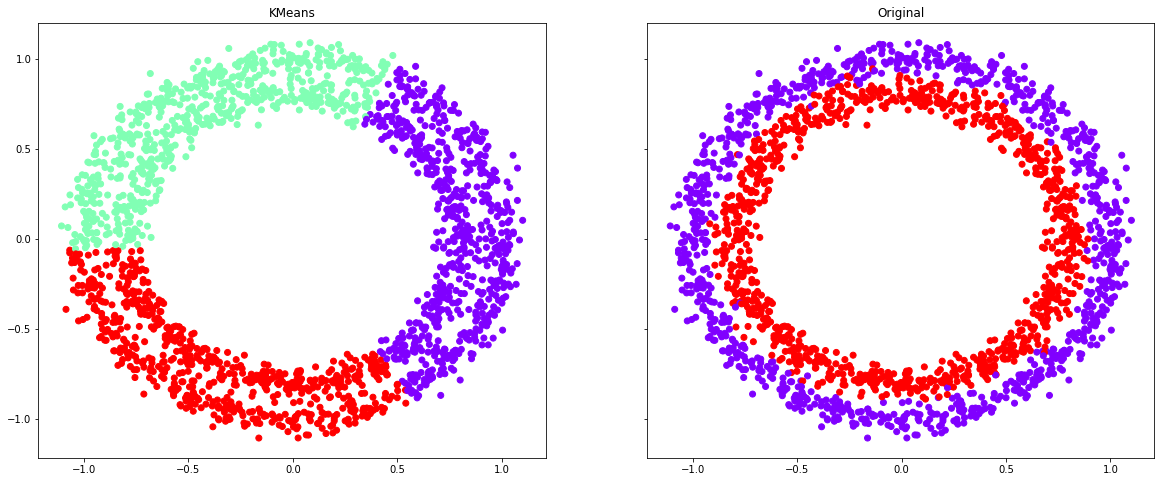

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
# kmeans = KMeans(n_clusters=6)
# kmeans = KMeans(n_clusters=9)
# kmeans = KMeans(n_clusters=27)
kmeans.fit(x[0])
kmeans.cluster_centers_
kmeans.labels_


f,(ax1,ax2)=plt.subplots(1,2,sharey=True,figsize=(20,8))
ax1.set_title("KMeans")
ax1.scatter(x[0][:,0],x[0][:,1],c=kmeans.labels_,cmap="rainbow")
ax2.set_title("Original")
ax2.scatter(x[0][:,0],x[0][:,1],c=x[1],cmap="rainbow")


ENTROPIA

In [ ]:
import scipy as sp #ENTROPIA
sp.stats.entropy(kmeans.labels_) #entropia

7.1382037894493084

COESÃO

In [ ]:
kmeans.inertia_ #coesao

534.9154093315562

SEPARABILIDADE

No handles with labels found to put in legend.


Distância Euclidiana do Ponto D1 ao D2:  1.1514806465918646


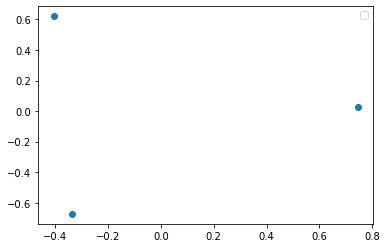

In [ ]:
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1]) #separabilidade
plt.legend()
plt.show

import numpy as np
a = np.array(kmeans.cluster_centers_[:,0])
b = np.array(kmeans.cluster_centers_[:,1])

d1=(a[0],b[0]) #x e y do primeiro centroide
d2=(a[1],b[1]) #x e y de outro centroide 
dist = np.sqrt(np.sum(np.square(d1[0]-d2[0]))) #Calcula a distancia
print("Distância Euclidiana do Ponto D1 ao D2: ",dist)


COEFICIENTE DE SILHUETA

In [ ]:
from sklearn.metrics import silhouette_score

db = db.value
s = silhouette_score(db, lables, metric='sqeuclidean')

AttributeError: ignored

DBSACAN

/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


[0 0 0 ... 0 0 0]


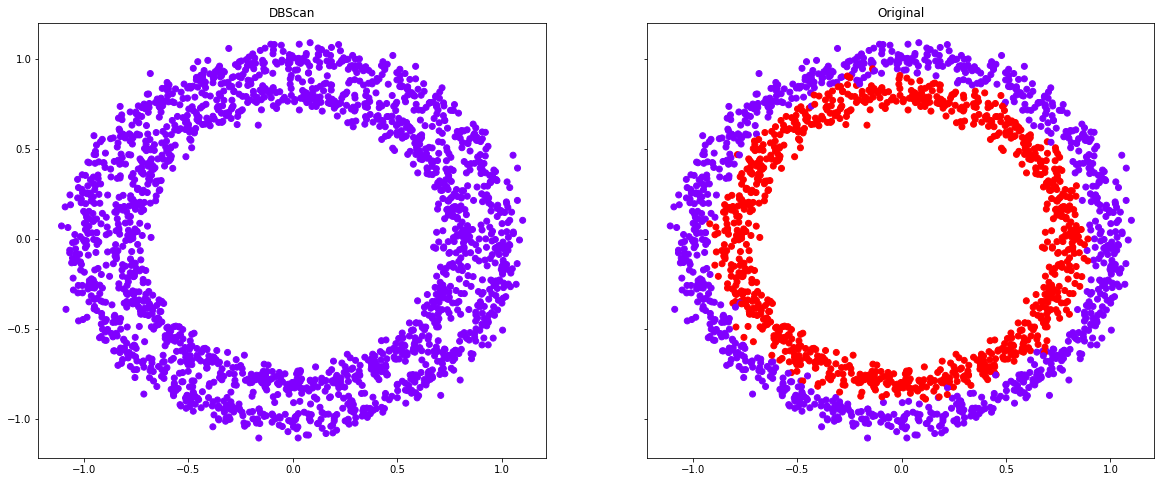

In [ ]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=1, min_samples=5).fit(x[0])
# dbscan = DBSCAN(eps=1, min_samples=10).fit(x[0])
# dbscan = DBSCAN(eps=1, min_samples=15).fit(x[0])
# dbscan = DBSCAN(eps=1, min_samples=20).fit(x[0])

f,(ax1,ax2)=plt.subplots(1,2,sharey=True,figsize=(20,8))
ax1.set_title("DBScan")
ax1.scatter(x[0][:,0],x[0][:,1],c=dbscan.labels_,cmap="rainbow")
ax2.set_title("Original")
ax2.scatter(x[0][:,0],x[0][:,1],c=x[1],cmap="rainbow")
print(dbscan.labels_)


In [ ]:
import scipy as sp 
sp.stats.entropy(dbscan.labels_) #entropia
print(dbscan.labels_)

[0 0 0 ... 0 0 0]


/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


In [ ]:
dbscan.inertia_ #coesao

AttributeError: ignored

SILHUETA


AGNES


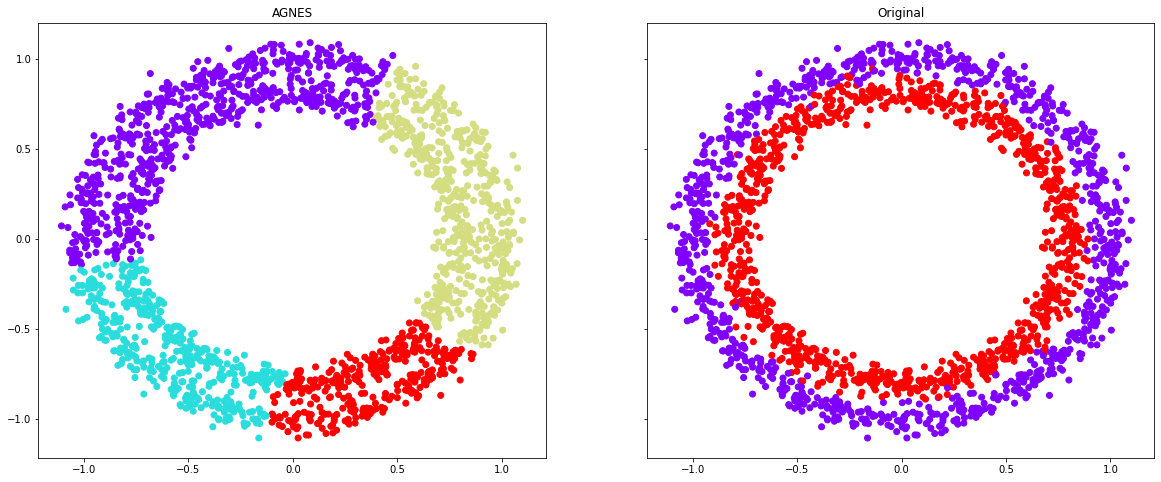

In [ ]:
from sklearn.cluster import AgglomerativeClustering
agnes = AgglomerativeClustering(n_clusters=4,linkage="ward").fit(x[0])
import scipy as sp 
sp.stats.entropy(agnes.labels_) #entropia

f,(ax1,ax2)=plt.subplots(1,2,sharey=True,figsize=(20,8))
ax1.set_title("AGNES")
ax1.scatter(x[0][:,0],x[0][:,1],c=agnes.labels_,cmap="rainbow")
ax2.set_title("Original")
ax2.scatter(x[0][:,0],x[0][:,1],c=x[1],cmap="rainbow")



In [ ]:
agnes.inertia_ #coesao

AttributeError: ignored

.


In [ ]:
from sklearn import metrics
print(x[1])
print(kmeans.labels_)
print(dbscan.labels_)
print(agnes.labels_)
print("Score K-means: ",metrics.rand_score(x[1],kmeans.labels_))
print("Score DbScan: ",metrics.rand_score(x[1],dbscan.labels_))
print("Score Agnes: ",metrics.rand_score(x[1],agnes.labels_))


[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [0]]
[3 0 2 ... 3 0 3]
[0 0 0 ... 0 0 0]
[3 1 0 ... 2 1 3]


ValueError: ignored